# Data Pre-processing to make atomic event - similarity map
use cosine similarity score..?

In [20]:
import h5py
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

video_info_path = '/mnt/GitHub/G_TAD_customizing/data/thumos_annotations/'
video_ft_path = '/mnt/GitHub/G_TAD_customizing/data/thumos_feature/TSN_pretrain_avepool_allfrms_hdf5/'
# annotations path
valid_path = os.path.join(video_info_path, 'val_Annotation.csv')
test_path = os.path.join(video_info_path, 'test_Annotation.csv')

# features path
valid_rgb = os.path.join(video_ft_path, 'rgb_val.h5')
valid_flow = os.path.join(video_ft_path, 'flow_val.h5')
test_rgb = os.path.join(video_ft_path, 'rgb_test.h5')
test_flow = os.path.join(video_ft_path, 'flow_test.h5')

In [21]:
anno_df_valid = pd.read_csv(valid_path)

In [22]:
video_name_list = sorted(list(set(anno_df_valid.video.values[:])))
video_name_list

['video_validation_0000051',
 'video_validation_0000052',
 'video_validation_0000053',
 'video_validation_0000054',
 'video_validation_0000055',
 'video_validation_0000056',
 'video_validation_0000057',
 'video_validation_0000058',
 'video_validation_0000059',
 'video_validation_0000060',
 'video_validation_0000151',
 'video_validation_0000152',
 'video_validation_0000153',
 'video_validation_0000154',
 'video_validation_0000155',
 'video_validation_0000156',
 'video_validation_0000157',
 'video_validation_0000158',
 'video_validation_0000159',
 'video_validation_0000160',
 'video_validation_0000161',
 'video_validation_0000162',
 'video_validation_0000163',
 'video_validation_0000164',
 'video_validation_0000165',
 'video_validation_0000166',
 'video_validation_0000167',
 'video_validation_0000168',
 'video_validation_0000169',
 'video_validation_0000170',
 'video_validation_0000171',
 'video_validation_0000172',
 'video_validation_0000173',
 'video_validation_0000174',
 'video_valida

In [23]:
# read in raw feature files extracted by TSN
flow_val_ft = h5py.File(valid_flow, 'r')
rgb_val_ft = h5py.File(valid_rgb, 'r')

In [24]:
# vid_sim = []
similarity_info = {}

for cnt, i in enumerate(video_name_list):
    # get feature for each video
    tmp = np.array(flow_val_ft[i])
    
    # get similarity matrix
    sim_mat = tmp @ (tmp.T)
    
    # in order to divide to norm of each vector
    tmp_norm = np.linalg.norm(tmp, axis=1)
    tmp_norm = tmp_norm.reshape(-1, 1)
    
    # calculate norm mult norm
    norm = tmp_norm @ tmp_norm.T
    
    # calculate final cosine similarity
    similarity = np.divide(sim_mat, norm)
    # vid_sim.append(similarity)
    # print(similarity)
    # plt.imshow(similarity)
    similarity_info[i] = similarity
    if cnt > 1:
        break


In [25]:
similarity_info[list(similarity_info.keys())[0]].shape

(5090, 5090)

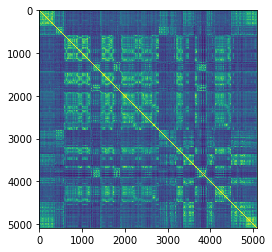

In [26]:
plt.imshow(similarity_info[list(similarity_info.keys())[0]])

In [27]:
max(similarity_info[list(similarity_info.keys())[0]][0])

1.0000001

In [28]:
min(similarity_info[list(similarity_info.keys())[0]][0])

0.0197635

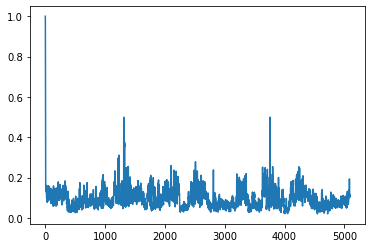

In [29]:
plt.plot(similarity_info[list(similarity_info.keys())[0]][0])

In [30]:
threshold = 0.4

In [31]:
tmp = similarity_info[list(similarity_info.keys())[0]][0] > threshold

In [32]:
list(tmp).count(True)

12

In [33]:
"""
unsup_tep.py
****
Finds square-like similarity matrix from pre-extrated features from 3D CNN model.
"""
# %%
# import things
import numpy as np
from tqdm import tqdm
from os.path import join
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import argparse
import pickle
import copy
from itertools import combinations
%matplotlib inline

In [34]:
# bunch of functions
# cosine similarity
def cos_sim_mat(test_feat):
    """
    returns cosine similarity matrix of given vectors.
    """
    dist_out = 1-pairwise_distances(test_feat, metric="cosine")
    return dist_out


# 1D pca function
def pca1(input_mat):
    """
    does 1D-PCA on given vectors.
    the vectors shoulbe be in shape of (num_samples, num_features)
    returns:
        - 1D-PCA result of given vectors.
    """
    pca = PCA(n_components=1,whiten=True)
    pca_ed = np.squeeze(pca.fit_transform(input_mat))
    return pca_ed

# diagonal matrix function
def get_diagonal_matrix(ref_mat,thickness=1):
    """
    makes diagonal identity matrix of custom thickness
    args:
        - ref_mat: reference square matrix. the output will be the same shape with ref_mat.
        - thickness: thickness of diagonal matrix
    returns:
        - identity matrix of shape ref_mat.shape, thickness of "thickness" arg.
    """
    diag_mat = np.identity(ref_mat.shape[0])
    for i in range(1,thickness):
        id_mat = np.identity(ref_mat.shape[0])
        right_mat = np.concatenate([id_mat[i:],np.zeros([i,*id_mat.shape[1:]])])
        left_mat = np.concatenate([np.zeros([i,*id_mat.shape[1:]]),id_mat[:-i]])
        diag_mat += right_mat
        diag_mat += left_mat
    return diag_mat

def center_cleansing(mat,clean_thickness=2,avg_length=2):
    """
    make diagonal elements of given matrix smooth, 
    by replacing their values with weighted-mean(adjcent elements)
    (not used now)
    """
    center_mask = get_diagonal_matrix(mat,clean_thickness)
    avg_mask = get_diagonal_matrix(mat,clean_thickness+avg_length)
    avg_mask = avg_mask - center_mask
    avg_sums =  np.mean(mat * avg_mask,axis=1)
    avg_cnts = np.mean(avg_mask > 1e-5,axis=1)
    avg_values = avg_sums / avg_cnts
    center_values = center_mask * np.expand_dims(avg_values,axis=1)
    new_mat = np.array(mat)
    new_mat[center_mask > 1e-5] = 0.0
    new_mat += center_values
    return new_mat

def mat_thresh(mat):
    """
    adaptively threshold given matrix.
    The threshold value is determined by
    (mean(mat) + 1.0) / 2
    """
    avg_val = np.mean(mat)
    avg_thresh = (avg_val + 1) / 2
    new_mat = np.array(mat)
    new_mat[mat>avg_thresh] = avg_thresh
    return new_mat

def kmeans_clustering(mat,time_scale=1,n_clusters=3):
    """
    Does k-means clustering, but attaches relative timestamp as feature of input vector to encourage the resulting classes time-related.
    the input vectors shoulbe be in shape of (num_samples, num_features).
    args:
        - mat: input vectors. shoulbe be in shape of (num_samples, num_features).
        - time_scale: the weight applied to time feature.
        - n_clusters: number of k-means clusters
    """
    mat_length = mat.shape[0]
    timestamps = np.expand_dims(np.linspace(start=0,stop=time_scale,num=mat_length),axis=1)
    mat_with_timestamps = np.concatenate([mat,timestamps],axis=1)
    kmeans = KMeans(n_clusters=n_clusters,tol=1e-5,max_iter=400, random_state=1234)
    kmeans_classes = kmeans.fit_predict(mat_with_timestamps)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_centers = np.array(kmeans_centers)
    return kmeans_classes, kmeans_centers

def flatten_class(class_sequence,window_size=5  ):
    """
    tries to remove sudden incorrect occurances(noisy labels) by smoothing out the class sequence.
    does sliding window, that selects most frequent element in the window.
    args:
        - class_sequence: the sequence of k-means classes. this is an output of [kmens_clustering] function.
        - window_size: sliding window size. should be odd.
    """
    radius = window_size // 2
    flattened_sequence = np.array(class_sequence)
    for center in range(len(class_sequence)):
        close_elements = class_sequence[max(0,center-radius):min(center+radius,len(class_sequence))]
        most_frequent_class = np.argmax(np.bincount(close_elements))
        flattened_sequence[center] = most_frequent_class
    return flattened_sequence

def merge_classes(class_sequence,kmeans_centers,thresh=0.996):
    """
    given k-means results (class sequence and cluster centers), 
    merge classes that have too close centers.
    args:
        - class_sequence: the sequence of k-means classes. I recommand using the output of [flatten_class] fuction
        - kmeans_centers: the center vector k-means clustering. i.e. an output of [kmeans_clustering] function.
        - thresh: merging threshold of class center similarity (metric: cosine similarity)
    returns:
        - class sequence with merged classes
    """
    num_classes = kmeans_centers.shape[0]
    class_counts = np.bincount(class_sequence)
    class_similarity = cos_sim_mat(kmeans_centers) - np.identity(num_classes)
    for i in range(num_classes):
        for j in range(i+1,num_classes):
            if class_similarity[i,j] > thresh:
                if class_counts[i] >= class_counts[j]:
                    class_sequence[class_sequence == j] = i
                else:
                    class_sequence[class_sequence == i] = j
    return class_sequence

def get_transition_sites(class_sequence):
    """
    given class sequcne, finds transition sites.
    args:
        - class_sequence: the sequence of k-means classes. I recommand using the output of [merge_classes] function
    """
    current_class = class_sequence[0]
    transition_sites = []
    transition_sites.append(0)
    for i,val in enumerate(class_sequence):
        if val != current_class:
            current_class = val
            transition_sites.append(i)
    transition_sites.append(len(class_sequence))
    return transition_sites

def remove_short_transition(transition_sites,thresh=120):
    """
    removes transitions that are too close from others.
    """
    if len(transition_sites) < 4:
        return transition_sites
    for i in range(len(transition_sites) - 1):
        forward_difference = transition_sites[i+1] - transition_sites[i]
        if forward_difference <= thresh:
            transition_sites[i] = transition_sites[-1]
    transition_sites.append(0)
    transition_sites = list(set(transition_sites))
    transition_sites = sorted(transition_sites)
    return transition_sites

clustering trials :  0
clustering trials :  1
clustering trials :  2
clustering trials :  3
clustering trials :  4
clustering trials :  5
boundary count 13
0
7
584
1209
1445
1907
3205
3363
3694
3920
4107
4539
5090


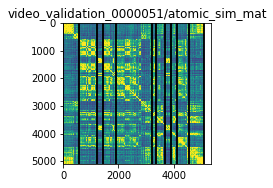

clustering trials :  0
clustering trials :  1
clustering trials :  2
clustering trials :  3
clustering trials :  4
clustering trials :  5
boundary count 9
0
242
1900
2301
2616
2834
4544
4824
4990


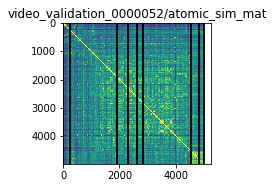

In [35]:
# ATOMIC EVENT VISUALIZATION

# show demo

clustering_trials = 6
transition_boundary_info = {}
for cnt, i in tqdm(enumerate(video_name_list)):
    sim_mat = similarity_info[i]
    another_sim_mat = mat_thresh(sim_mat)
    # another_sim_mat = sim_mat # just use it directly
    max_points = 0
    top_transition_sites = None
    for j in range(clustering_trials):
        # print('clustering trials : ', j)
        kmeans_classes, kmeans_centers = kmeans_clustering(another_sim_mat)
        kmeans_classes = merge_classes(kmeans_classes,kmeans_centers)
        kmeans_classes = flatten_class(kmeans_classes)
        transition_sites = get_transition_sites(kmeans_classes)
        transition_sites = remove_short_transition(transition_sites)
        if len(transition_sites) > max_points:
            max_points = len(transition_sites)
            top_transition_sites = transition_sites
    # draw sim mat
    fig = plt.figure(num=3,figsize=(9,3))
    # draw thresholded version
    fig.add_subplot(1,3,1)
    plt.imshow(another_sim_mat)
    for t in top_transition_sites:
        plt.axvline(t,color='k')
    plt.title("{}/atomic_sim_mat".format(i))
    print('boundary count', len(top_transition_sites))
    for t in top_transition_sites:
        plt.axvline(t,color='k')
        print(t)
    transition_boundary_info[i] = {"top_transition_sites":top_transition_sites, "frames":sim_mat.shape[0]}
    plt.show()
    if cnt > 0:
        break

In [36]:
transition_boundary_info

{'video_validation_0000051': {'top_transition_sites': [0,
   7,
   584,
   1209,
   1445,
   1907,
   3205,
   3363,
   3694,
   3920,
   4107,
   4539,
   5090],
  'frames': 5090},
 'video_validation_0000052': {'top_transition_sites': [0,
   242,
   1900,
   2301,
   2616,
   2834,
   4544,
   4824,
   4990],
  'frames': 4990}}

In [ ]:
# using the transition_boundary_info -> average the features based on this
for 